In [1]:
import copy
from typing import Dict, Any, List, Tuple, Union, Callable
from pathlib import Path
import tempfile
import json
from itertools import product

from allennlp.common import Params
import target_extraction
from target_extraction.allen import AllenNLPModel
from target_extraction.analysis.sentiment_metrics import get_labels
from target_extraction.data_types import TargetTextCollection
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from textwrap import wrap
import seaborn as sns

import lstm
import thesis_statistics as thesis_stats
import config

matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

def plot_score_confidences(scores: np.ndarray, confidences: np.ndarray,
                           x_values: List[Union[str, int, float]], 
                           ax: matplotlib.axes,
                           x_label: str, y_label: str, title: str = '',
                           **plot_kwargs) -> 'matplotlib.axes.Axes':
    '''
    Given point estimate(s) and the confidence range(s) will plot the estimates
    and confidences as an error bar plot.

    :param scores: Vector of point estimate(s), shape = [n]
    :param confidences: Vector of confidence range(s), shape = []
    :param x_values: List of values to put on the X axis e.g. names of the
                     models that created the point estimates.
    :param ax: A Matplotlib axes to draw with.
    :param x_label: Label to assign to the X axis.
    :param y_label: Label to assign to the Y axis.
    :param title: Title of the plot. Optional if '' given then no title.
    :param **plot_kwargs: Keyword arguments to the
                          :py:func:`matplotlib.axes.Axes.errorbar`
    :return: The matplotlib axes that stores the plot information as an error
             bar plot.
    '''
    num_scores = scores.shape[0]
    scores = scores.reshape((num_scores, 1))
    yerrs = np.abs((scores - confidences).T)
    for i, x in enumerate(x_values):
        yerr = yerrs[:, i].reshape((2, 1))
        if i!=0 and 'label' in plot_kwargs:
            plot_kwargs.pop('label')
        ax.errorbar([x_values[i]], scores[i], yerr=yerr,
                    fmt="bo", capsize=5, zorder=i, **plot_kwargs)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if title:
        ax.set_title(title)
    return ax

def plot_model_metrics(y_test: np.ndarray, preds: np.ndarray, 
                       metric: Callable[[np.ndarray, np.ndarray], float], 
                       **metric_kwargs) -> np.ndarray:
    model_metric = [metric(y_test, pred, **metric_kwargs) for pred in preds]
    return np.array(model_metric) * 100

def confidence_plots(predictions: np.ndarray, boot_predictions: List[np.ndarray], 
                     y_test: np.ndarray, 
                     metrics: List[Callable[[np.ndarray, np.ndarray], float]], 
                     metrics_kwargs: List[Union[None, Dict[str, Any]]],
                     metric_names: List[str], model_names: List[str],
                     original_scores: List[float], dataset_name: str,
                     model_group_name: str,
                     figsize: Tuple[int, int] = (15, 7), axs=None):
    
    number_metrics = len(metric_names)
    if axs is None:
        fig, axs = plt.subplots(1, number_metrics, figsize=figsize)
    model_names = ['\n'.join(wrap(name, 15)) 
                   for name in model_names]
    
    for metric_index, boot_prediction in enumerate(boot_predictions):
        metric_name = metric_names[metric_index]
        confidence_ranges = [thesis_stats.confidence_range(boot_preds, 0.05, 'two') 
                             for boot_preds in boot_prediction.T]
        confidence_ranges = np.array(confidence_ranges) * 100
        
        metric_func = metrics[metric_index]
        metric_kwargs = metrics_kwargs[metric_index]
        if metric_kwargs:
            model_score = plot_model_metrics(y_test, predictions.T, 
                                        metric_func, **metric_kwargs)
        else:
            model_score = plot_model_metrics(y_test, predictions.T, metric_func)
        if len(boot_predictions) > 1:
            plot_ax = axs[metric_index]
        else:
            plot_ax = axs
        #plot_title = f'{model_group_name} Models {metric_name} on\n{dataset_name} Test Data'
        plot_title = ''
        plot_ax = plot_score_confidences(model_score, 
                                         confidence_ranges, 
                                         model_names, plot_ax,
                                         'Models', f'{metric_name} (%)',
                                         plot_title,
                                         label='Reproduced')
        plot_ax.plot(model_names, original_scores[metric_index], 'r^', label='Original')
        plot_ax.legend()
    return plot_ax


def predictions(model_name, split_name, embedding_name, preidction_collection, save_dir):
    result_fp = save_dir / f'Dong {model_name} {split_name} {embedding_name}.json'
    labels = get_labels(preidction_collection, 'target_sentiments', 'predicted_sentiment')
    with result_fp.open('w+') as result_file:
        json.dump(labels, result_file)

def add_word_vector(word_vector_name: str, params_dict: Dict[str, any], 
                    model_name: str, file_path: Path) -> Path:
    temp_params_dict = copy.deepcopy(params_dict)
    word_embedding_fp = None
    dimension = 0
    if word_vector_name == 'Twitter 200':
        word_embedding_fp = config.WORD_EMBEDDING_DIR / 'glove.twitter.27B.200d.txt'
        dimension = 200
    elif word_vector_name == 'Twitter 100':
        word_embedding_fp = config.WORD_EMBEDDING_DIR / 'glove.twitter.27B.100d.txt'
        dimension = 100
    elif word_vector_name == 'Twitter 50':
        word_embedding_fp = config.WORD_EMBEDDING_DIR / 'glove.twitter.27B.50d.txt'
        dimension = 50
    elif word_vector_name == 'GloVe 300':
        word_embedding_fp = config.WORD_EMBEDDING_DIR / 'glove.840B.300d.txt'
        dimension = 300
    elif word_vector_name == 'SSWE':
        word_embedding_fp = config.WORD_EMBEDDING_DIR / 'new_sswe-u.txt'
        dimension = 50
    else:
        raise ValueError(f'word_vector_name {word_vector_name} is not one of accepted names.')
    assert word_embedding_fp is not None
    word_embedding_fp = str(word_embedding_fp)
    if model_name in ['TDLSTM', 'TCLSTM']:
        temp_params_dict['model']['context_field_embedder']['token_embedders']['tokens']['embedding_dim'] = dimension
        temp_params_dict['model']['context_field_embedder']['token_embedders']['tokens']['pretrained_file'] = word_embedding_fp
    elif model_name == 'LSTM':
        temp_params_dict['model']['embedder']['token_embedders']['tokens']['embedding_dim'] = dimension
        temp_params_dict['model']['embedder']['token_embedders']['tokens']['pretrained_file'] = word_embedding_fp
    else:
        raise ValueError(f'The model name {model_name} is not a recognised model name')
    if model_name == 'TDLSTM':
        temp_params_dict['model']['left_text_encoder']['hidden_size'] = dimension
        temp_params_dict['model']['left_text_encoder']['input_size'] = dimension
        temp_params_dict['model']['right_text_encoder']['hidden_size'] = dimension
        temp_params_dict['model']['right_text_encoder']['input_size'] = dimension
    elif model_name == 'TCLSTM':
        temp_params_dict['model']['left_text_encoder']['hidden_size'] = dimension
        temp_params_dict['model']['left_text_encoder']['input_size'] = dimension * 2
        temp_params_dict['model']['right_text_encoder']['hidden_size'] = dimension
        temp_params_dict['model']['right_text_encoder']['input_size'] = dimension * 2
        temp_params_dict['model']['target_encoder']['embedding_dim'] = dimension
    elif model_name == 'LSTM':
        temp_params_dict['model']['encoder']['hidden_size'] = dimension
        temp_params_dict['model']['encoder']['input_size'] = dimension
    else:
        raise ValueError(f'The model name {model_name} is not a recognised model name')
    #print(temp_params_dict)
    return Params(temp_params_dict).to_file(file_path)

def load_convert_results(result_data: Tuple[List[str], List[List[str]]],
                         mapper: Dict[str, int]) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Returns a tuple of true values and predictions where the true values is
    of shape (n_sample) and the predictions are of shape (n_samples, num_runs)
    '''
    true_values, run_prediction_values = result_data
    true_values = np.array([mapper[value] for value in true_values])
    run_prediction_values = [[mapper[prediction] for prediction in predictions] 
                              for predictions in run_prediction_values]
    return true_values, np.array(run_prediction_values).T

def get_score(true_values: np.ndarray, run_predictions: np.ndarray, 
              metric, **metric_kwargs) -> np.ndarray:
    num_runs = run_predictions.shape[1]
    scores = []
    for run in range(num_runs):
        scores.append(metric(true_values, run_predictions[:, run], 
                      **metric_kwargs))
    return np.array(scores)

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

def get_best_performing_run(output_load_convert_results: Tuple[np.ndarray, np.ndarray]
                            ) -> Tuple[int, int]:
    true_values, pred_values = output_load_convert_results
    acc_values = get_score(true_values, pred_values, accuracy_score)
    f1_values = get_score(true_values, pred_values, f1_score, average='macro')
    return acc_values.argmax(), f1_values.argmax()

def get_median_performing_run(output_load_convert_results: Tuple[np.ndarray, np.ndarray]
                            ) -> Tuple[int, int]:
    true_values, pred_values = output_load_convert_results
    acc_values = get_score(true_values, pred_values, accuracy_score)
    f1_values = get_score(true_values, pred_values, f1_score, average='macro')
    return acc_values.argsort()[acc_values.shape[0]//2], f1_values.argsort()[acc_values.shape[0]//2]
label_mapper = {'positive': 2, 'negative': 1, 'neutral': 3}


In [2]:
# Dong Neural Twitter datasets
dong_train_fp = config.neural_dataset_dir / f'Dong train.json'
dong_val_fp = config.neural_dataset_dir / f'Dong validation.json'
dong_test_fp = config.neural_dataset_dir / f'Dong test.json'
dong_train = TargetTextCollection.load_json(dong_train_fp)
dong_validation = TargetTextCollection.load_json(dong_val_fp)
dong_test = TargetTextCollection.load_json(dong_test_fp)

In [3]:
%%capture
patience_values = ["5", "10"]
for patience_value in patience_values:
    for embedding_name in ['Twitter 50', 'Twitter 100', 'Twitter 200', 'GloVe 300', 'SSWE']:
        for model_name in ['LSTM', 'TDLSTM', 'TCLSTM']:
            #print(f'{model_name} {embedding_name}')
            result_dir = config.RESULTS_DIR / "neural" / "reproduction" / f"patience {patience_value}"
            val_result_fp = result_dir / f'Dong {model_name} validation {embedding_name}.json'
            test_result_fp = result_dir / f'Dong {model_name} test {embedding_name}.json'
            if val_result_fp.exists() and test_result_fp.exists():
                continue
            
            val_copy = TargetTextCollection(copy.deepcopy(list(dong_validation.values())))
            test_copy = TargetTextCollection(copy.deepcopy(list(dong_test.values())))
            base_config = config.MODEL_CONFIG_DIR / f"patience {patience_value}" / f"{model_name}.jsonnet"
            predictor = 'target-sentiment'
            for i in range(20):
                with tempfile.NamedTemporaryFile() as temp_file:
                    temp_file_path = Path(temp_file.name)
                    add_word_vector(embedding_name, Params.from_file(base_config).as_dict(), 
                                    model_name, temp_file_path)
                    a_model = AllenNLPModel(model_name, temp_file_path, predictor, save_dir=None)
                    a_model.fit(train_data=dong_train, val_data=dong_validation, test_data=dong_test)
                    a_model.predict_into_collection(val_copy, {'sentiments': 'predicted_sentiment'}, batch_size=32)
                    a_model.predict_into_collection(test_copy, {'sentiments': 'predicted_sentiment'}, batch_size=32)
            predictions(model_name, 'validation', embedding_name, val_copy, result_dir)
            predictions(model_name, 'test', embedding_name, test_copy, result_dir)

In [4]:
from collections import defaultdict
results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: dict())))
embedding_names = ['SSWE', 'Twitter 50', 'Twitter 100', 'Twitter 200', 'GloVe 300']
model_names = ['LSTM', 'TDLSTM', 'TCLSTM']
splits = ['test', 'validation']
metrics = ['Accuracy', 'F1']

result_model_names = []
result_splits = []
result_embedding_names = []
result_metric = []
result_scores = []
result_patience_values = []
for patience_value in patience_values:
    for embedding_name in embedding_names:
        for model_name in model_names:
            for split in splits:
                result_dir = config.RESULTS_DIR / "neural" / "reproduction" / f"patience {patience_value}"
                result_fp = result_dir / f'Dong {model_name} {split} {embedding_name}.json'
                with result_fp.open('r') as result_file:
                    a_result = json.load(result_file)
                    a_result = load_convert_results(a_result, label_mapper)
                    results[patience_value][embedding_name][model_name][split] = a_result

                    for metric in metrics:
                        metric_scores = None
                        if metric == 'Accuracy':
                            metric_scores = get_score(a_result[0], a_result[1], accuracy_score)
                        elif metric == 'F1':
                            metric_scores = get_score(a_result[0], a_result[1], f1_score, average='macro')
                        assert metric_scores is not None
                        for score in metric_scores:
                            result_metric.append(metric)
                            result_model_names.append(model_name)
                            result_splits.append(split)
                            result_scores.append(score)
                            result_embedding_names.append(embedding_name)
                            result_patience_values.append(patience_value)
                

/home/andrew/Envs/thesis-chapter-5-linear-models/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


All results:

In [5]:

result_dict = {'Embedding': result_embedding_names, 'Method': result_model_names, 
               'Metric': result_metric, 'Split': result_splits, 
               'Score': result_scores, 'Patience': result_patience_values}
result_df = pd.DataFrame(result_dict)
result_df = result_df[result_df['Patience']=='10']
result_df = pd.pivot_table(data=result_df, values='Score', index=['Embedding', 'Metric'], 
                           columns=['Method', 'Split'], aggfunc=mean_std)
result_df.reindex(list(product(embedding_names, metrics)))

Method                        LSTM                      TCLSTM                \
Split                         test    validation          test    validation   
Embedding   Metric                                                             
SSWE        Accuracy  62.07 (1.48)  60.13 (1.24)  65.59 (1.41)  65.30 (1.09)   
            F1        58.37 (2.16)  56.13 (2.25)  61.96 (1.77)  61.14 (1.51)   
Twitter 50  Accuracy  61.48 (1.43)  59.13 (0.92)  64.74 (1.87)  63.94 (0.77)   
            F1        57.12 (2.79)  54.62 (2.47)  60.72 (2.57)  59.05 (1.56)   
Twitter 100 Accuracy  62.93 (0.81)  60.76 (0.91)  66.74 (1.32)  65.62 (1.01)   
            F1        58.59 (1.90)  56.23 (2.31)  63.26 (1.68)  61.20 (1.52)   
Twitter 200 Accuracy  62.49 (1.14)  61.08 (1.41)  67.89 (0.98)  66.35 (0.94)   
            F1        57.41 (2.81)  56.14 (2.73)  64.70 (1.39)  62.32 (1.38)   
GloVe 300   Accuracy  64.73 (0.76)  63.65 (0.94)  69.22 (1.27)  67.86 (1.29)   
            F1        61.04 (1.45)  60.32 (1.48)  66.47 (1.78)  64.35 (1.60)   

Method                      TDLSTM                
Split                         test    validation  
Embedding   Metric                                
SSWE        Accuracy  66.77 (1.63)  66.38 (1.18)  
            F1        63.35 (1.89)  62.63 (1.53)  
Twitter 50  Accuracy  65.11 (1.46)  64.36 (1.33)  
            F1        61.67 (2.00)  60.38 (1.74)  
Twitter 100 Accuracy  67.23 (1.08)  65.29 (0.96)  
            F1        63.86 (1.68)  61.54 (1.50)  
Twitter 200 Accuracy  68.11 (0.54)  66.44 (0.92)  
            F1        65.21 (0.94)  63.40 (1.51)  
GloVe 300   Accuracy  71.04 (0.68)  68.29 (0.66)  
            F1        68.43 (0.83)  65.16 (0.87)

Test:

In [6]:
test_results = pd.DataFrame(result_dict)
test_results = test_results[test_results['Patience']=='10']
test_results = test_results[test_results['Split']=='test']
test_results_pivot = pd.pivot_table(data=test_results, values='Score', 
                              index=['Embedding', 'Metric'], 
                              columns=['Method'], aggfunc=mean_std)
test_results_pivot.reindex(list(product(embedding_names, metrics))).reindex(model_names, axis=1)

Method                        LSTM        TDLSTM        TCLSTM
Embedding   Metric                                            
SSWE        Accuracy  62.07 (1.48)  66.77 (1.63)  65.59 (1.41)
            F1        58.37 (2.16)  63.35 (1.89)  61.96 (1.77)
Twitter 50  Accuracy  61.48 (1.43)  65.11 (1.46)  64.74 (1.87)
            F1        57.12 (2.79)  61.67 (2.00)  60.72 (2.57)
Twitter 100 Accuracy  62.93 (0.81)  67.23 (1.08)  66.74 (1.32)
            F1        58.59 (1.90)  63.86 (1.68)  63.26 (1.68)
Twitter 200 Accuracy  62.49 (1.14)  68.11 (0.54)  67.89 (0.98)
            F1        57.41 (2.81)  65.21 (0.94)  64.70 (1.39)
GloVe 300   Accuracy  64.73 (0.76)  71.04 (0.68)  69.22 (1.27)
            F1        61.04 (1.45)  68.43 (0.83)  66.47 (1.78)

Validation:

In [7]:
val_results = pd.DataFrame(result_dict)
val_results = val_results[val_results['Patience']=='10']
val_results = val_results[val_results['Split']=='validation']
val_results_pivot = pd.pivot_table(data=val_results, values='Score', 
                              index=['Embedding', 'Metric'], 
                              columns=['Method'], aggfunc=mean_std)
val_results_pivot.reindex(list(product(embedding_names, metrics))).reindex(model_names, axis=1)

Method                        LSTM        TDLSTM        TCLSTM
Embedding   Metric                                            
SSWE        Accuracy  60.13 (1.24)  66.38 (1.18)  65.30 (1.09)
            F1        56.13 (2.25)  62.63 (1.53)  61.14 (1.51)
Twitter 50  Accuracy  59.13 (0.92)  64.36 (1.33)  63.94 (0.77)
            F1        54.62 (2.47)  60.38 (1.74)  59.05 (1.56)
Twitter 100 Accuracy  60.76 (0.91)  65.29 (0.96)  65.62 (1.01)
            F1        56.23 (2.31)  61.54 (1.50)  61.20 (1.52)
Twitter 200 Accuracy  61.08 (1.41)  66.44 (0.92)  66.35 (0.94)
            F1        56.14 (2.73)  63.40 (1.51)  62.32 (1.38)
GloVe 300   Accuracy  63.65 (0.94)  68.29 (0.66)  67.86 (1.29)
            F1        60.32 (1.48)  65.16 (0.87)  64.35 (1.60)

In [8]:
dong_test_y = results['10']['Twitter 100']['LSTM']['test'][0]
all_metric_names = []
all_embedding_names = []
all_p_values = []
all_split_names = []
all_model_names = []
for metric_name in ['Accuracy', 'F1']:
    for split_name in ['test', 'validation']:
        for model_name in model_names:
            preds = []
            for embedding_name in embedding_names:
                model_embedding_results = results['10'][embedding_name][model_name][split_name]
                if metric_name == 'Accuracy':
                    best_index = get_median_performing_run(model_embedding_results)[0]
                elif metric_name == 'F1':
                    best_index = get_median_performing_run(model_embedding_results)[1]
                else:
                    raise ValueError('It has to be F1 or Accuracy')
                preds.append(np.expand_dims(model_embedding_results[1][:,best_index],1))
            preds = np.concatenate(preds, 1)
            pred_boot = thesis_stats.bootstrap(dong_test_y, preds, accuracy_score, n=10000)
            embedding_p_values = thesis_stats.bootstrap_one_t_test(pred_boot, embedding_names)
            glove_300_results = embedding_p_values['GloVe 300'].tolist()
            glove_300_other_embeddings = embedding_p_values['GloVe 300'].index.tolist()
            for p_result, other_embedding_name in zip(glove_300_results, glove_300_other_embeddings):
                all_p_values.append(p_result)
                all_embedding_names.append(other_embedding_name)
                all_metric_names.append(metric_name)
                all_split_names.append(split_name)
                all_model_names.append(model_name)

    

In [9]:
embedding_p_values_df = pd.DataFrame({'Method': all_model_names, 'Split': all_split_names, 
                                      'Embedding': all_embedding_names, 'P Value': all_p_values, 
                                      'Metric': all_metric_names})
embedding_p_values_df = embedding_p_values_df[embedding_p_values_df['Embedding']!='GloVe 300']
embedding_p_values_df_test = embedding_p_values_df[embedding_p_values_df['Split']=='test']
embedding_p_values_df_val = embedding_p_values_df[embedding_p_values_df['Split']=='validation']
pd.pivot_table(data=embedding_p_values_df_val, values='P Value', index=['Method', 'Embedding'], columns=['Metric'])

Metric              Accuracy      F1
Method Embedding                    
LSTM   SSWE           0.8897  0.4170
       Twitter 100    0.5980  0.9552
       Twitter 200    0.7919  0.9606
       Twitter 50     0.4799  0.9480
TCLSTM SSWE           0.9772  0.9468
       Twitter 100    0.2064  0.9247
       Twitter 200    0.3874  0.3908
       Twitter 50     0.3587  0.3731
TDLSTM SSWE           0.9875  0.8988
       Twitter 100    0.9099  0.4317
       Twitter 200    0.8964  0.6433
       Twitter 50     0.2980  0.9411

In [10]:
pd.pivot_table(data=embedding_p_values_df_test, values='P Value', index=['Method', 'Embedding'], columns=['Metric'])

Metric              Accuracy      F1
Method Embedding                    
LSTM   SSWE           0.0795  0.0470
       Twitter 100    0.1380  0.1498
       Twitter 200    0.0913  0.0419
       Twitter 50     0.0360  0.0229
TCLSTM SSWE           0.0065  0.0011
       Twitter 100    0.0215  0.0088
       Twitter 200    0.0993  0.0490
       Twitter 50     0.0005  0.0005
TDLSTM SSWE           0.0103  0.0017
       Twitter 100    0.0034  0.0010
       Twitter 200    0.0116  0.0068
       Twitter 50     0.0001  0.0000

Just the Twitter 100 results for the test set:

In [11]:
test_results_100 = test_results[test_results['Embedding']=='Twitter 100']
test_results_100_pivot = pd.pivot_table(data=test_results_100, values='Score', 
                              index=['Metric', 'Method'], 
                               aggfunc=[np.max, np.mean, np.min])
test_results_100_pivot = (test_results_100_pivot * 100).round(2)
test_results_100_pivot.reindex(list(product(metrics, model_names)))

amax   mean   amin
                 Score  Score  Score
Metric   Method                     
Accuracy LSTM    64.31  62.93  61.42
         TDLSTM  69.36  67.23  65.46
         TCLSTM  70.23  66.74  64.74
F1       LSTM    61.93  58.59  54.43
         TDLSTM  66.58  63.86  59.94
         TCLSTM  67.61  63.26  60.29

Testing if the methods using the Twitter 100 embeddings on the test set are significantly different to the original results for both metrics:

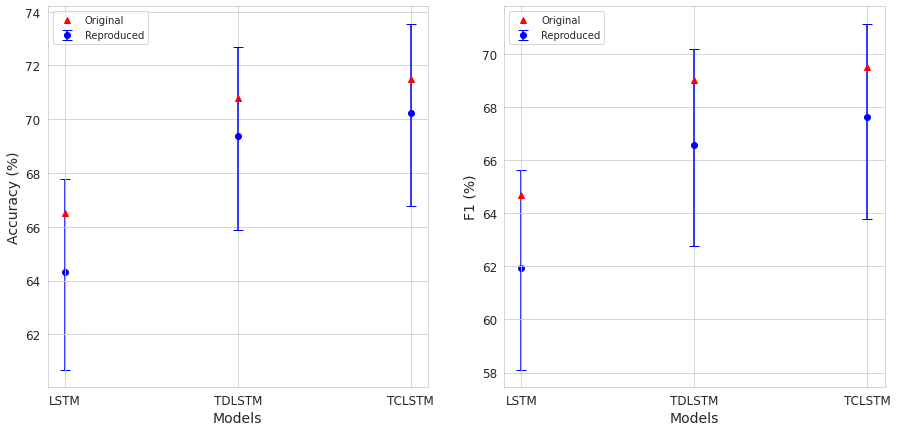

In [12]:
best_acc_test_preds = []
for model_name in model_names:  
    model_pred_values = results['10']['Twitter 100'][model_name]['test']
    best_index = get_best_performing_run(model_pred_values)[0]
    best_acc_test_preds.append(np.expand_dims(model_pred_values[1][:,best_index],1))
best_acc_test_preds = np.concatenate(best_acc_test_preds, 1)

best_f1_test_preds = []
for model_name in model_names:  
    model_pred_values = results['10']['Twitter 100'][model_name]['test']
    best_index = get_best_performing_run(model_pred_values)[1]
    best_f1_test_preds.append(np.expand_dims(model_pred_values[1][:,best_index],1))
best_f1_test_preds = np.concatenate(best_f1_test_preds, 1)

image_dir = config.IMAGES_DIR / 'Reproduction'
image_dir.mkdir(exist_ok=True, parents=True)

# Load true labels from the test set
dong_test_y = results['10']['Twitter 100']['LSTM']['test'][0]
# Create P-values for the accuracy metric using bootstrap
bootstrap_acc_preds = thesis_stats.bootstrap(dong_test_y, best_acc_test_preds, accuracy_score, n=10000)

fig, metric_axs = plt.subplots(1, 2, figsize=(15, 7))

boot_preds = [bootstrap_acc_preds]
metric_funcs = [accuracy_score]
metrics_kwargs = [None]
metric_names = ['Accuracy']
orginial_scores = [[66.5, 70.8, 71.5]]
metric_axs[0] = confidence_plots(best_acc_test_preds, boot_preds, dong_test_y, metric_funcs, metrics_kwargs, metric_names, model_names, orginial_scores, 'Dong', 'Target', axs=metric_axs[0])
#image_fp = str(Path(image_dir, 'LSTM_ACC.pdf').resolve())
#acc_ax.figure.savefig(image_fp, bbox_inches='tight')

# Load true labels from the test set
dong_test_y = results['10']['Twitter 100']['LSTM']['test'][0]
# Create P-values for the Macro-F1 metric using bootstrap
bootstrap_f1_preds = thesis_stats.bootstrap(dong_test_y, best_f1_test_preds, f1_score, average='macro', n=10000)

boot_preds = [bootstrap_f1_preds]
metric_funcs = [f1_score]
metrics_kwargs = [{'average': 'macro'}]
metric_names = ['F1']
orginial_scores = [[64.7, 69.0, 69.5]]
metric_axs[1] = confidence_plots(best_f1_test_preds, boot_preds, dong_test_y, metric_funcs, metrics_kwargs, metric_names, model_names, orginial_scores, 'Dong', 'Target', axs=metric_axs[1])

image_fp = str(Path(image_dir, 'LSTM_ACC_F1.pdf').resolve())
fig.savefig(image_fp, bbox_inches='tight')

Testing the number of times the best performing run for each method and metric on the test set is significantly better than all other runs for that method correct using Bonferroni:   

In [13]:
model_name_metric_number_better = defaultdict(lambda: dict())
true_values = results['10']['Twitter 100']['LSTM']['test'][0]
for model_name in model_names:
    pred_values = results['10']['Twitter 100'][model_name]['test']
    boot_preds = thesis_stats.bootstrap(true_values, pred_values[1], 
                                        accuracy_score, n=10000)
    boot_p_values = thesis_stats.bootstrap_one_t_test(boot_preds, 
                                                      [str(i) for i in range(20)])
    best_index = str(get_best_performing_run(pred_values)[0])
    number_better = thesis_stats.find_k_estimator(boot_p_values[best_index], 0.05)
    model_name_metric_number_better[model_name]['Accuracy'] = number_better

for model_name in model_names:
    pred_values = results['10']['Twitter 100'][model_name]['test']
    boot_preds = thesis_stats.bootstrap(true_values, pred_values[1], 
                                        f1_score,  average='macro', n=10000)
    boot_p_values = thesis_stats.bootstrap_one_t_test(boot_preds, 
                                                      [str(i) for i in range(20)])
    best_index = str(get_best_performing_run(pred_values)[1])
    number_better = thesis_stats.find_k_estimator(boot_p_values[best_index], 0.05)
    model_name_metric_number_better[model_name]['F1'] = number_better


In [14]:
pd.DataFrame(model_name_metric_number_better)

,LSTM,TDLSTM,TCLSTM
Accuracy,0,0,12
F1,5,1,15


Below we plot the distribution of results for the different methods on the test set for the GloVe Twitter 100 embedding.

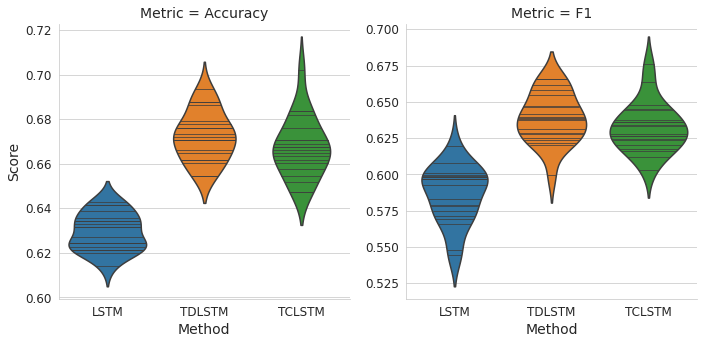

In [27]:
dist_ax = sns.catplot(x='Method', y='Score',  inner='stick', 
                      data=test_results_100, kind='violin',
                      col='Metric', sharey=False) 
image_fp = str(Path(image_dir, 'LSTM_DIST_ACC_F1.pdf').resolve())
dist_ax.savefig(image_fp, bbox_inches='tight')

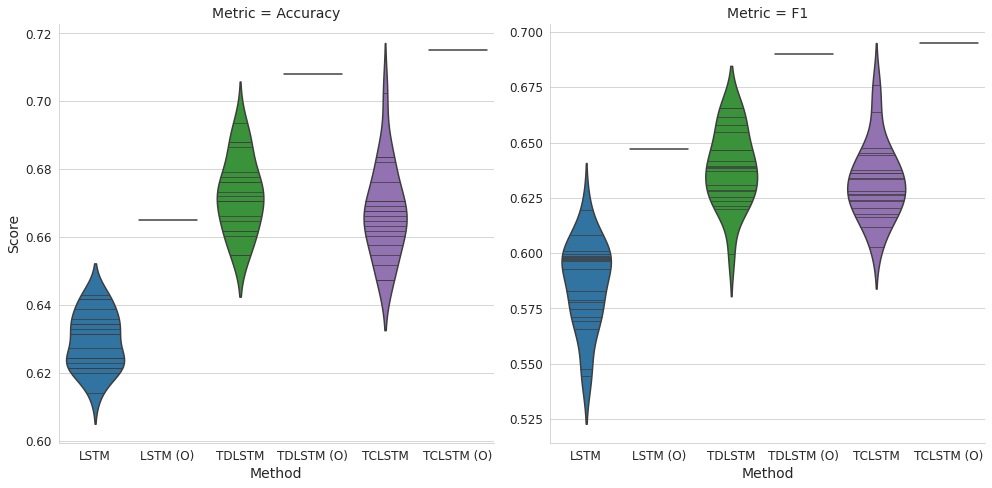

In [33]:
original_scores_for_plot = pd.DataFrame({'Method': ['LSTM (O)', 'LSTM (O)', 'TDLSTM (O)', 'TDLSTM (O)', 'TCLSTM (O)', 'TCLSTM (O)'], 'Score': [0.665,0.647,0.708,0.690,0.715,0.695], 'Metric': ['Accuracy', 'F1','Accuracy', 'F1','Accuracy', 'F1']})
combined_plot_scores = pd.concat([test_results_100, original_scores_for_plot])
combined_dist_ax = sns.catplot(x='Method', y='Score',  inner='stick', 
                               data=combined_plot_scores, kind='violin',
                               col='Metric', sharey=False, height=7, 
                               order=['LSTM', 'LSTM (O)', 'TDLSTM', 'TDLSTM (O)', 'TCLSTM', 'TCLSTM (O)']) 
image_fp = str(Path(image_dir, 'LSTM_DIST_ACC_F1_COMBINED.pdf').resolve())
combined_dist_ax.savefig(image_fp, bbox_inches='tight')